MultinomialNB.

shape: (3630, 4)
   Gender  Age  EstimatedSalary  Purchased
0       1   20         0.000000          0
1       1   19        13.666667          1
2       1   19         0.000000          0
3       0   20        12.400000          1
4       0   45        13.000000          1
<class 'pandas.core.frame.DataFrame'>
Index: 3630 entries, 0 to 4423
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Gender           3630 non-null   int64  
 1   Age              3630 non-null   int64  
 2   EstimatedSalary  3630 non-null   float64
 3   Purchased        3630 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 141.8 KB
None
           Gender  Age  EstimatedSalary  Purchased
NaN value       0    0                0          0


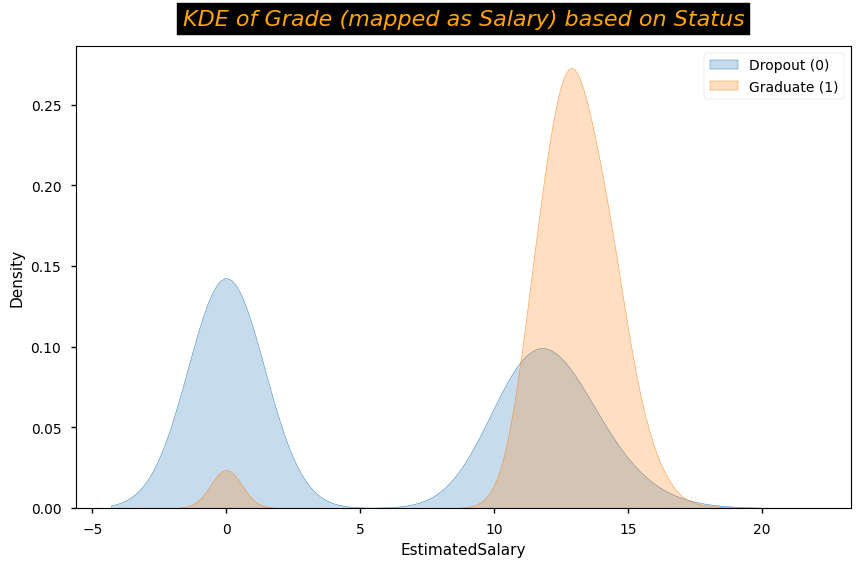

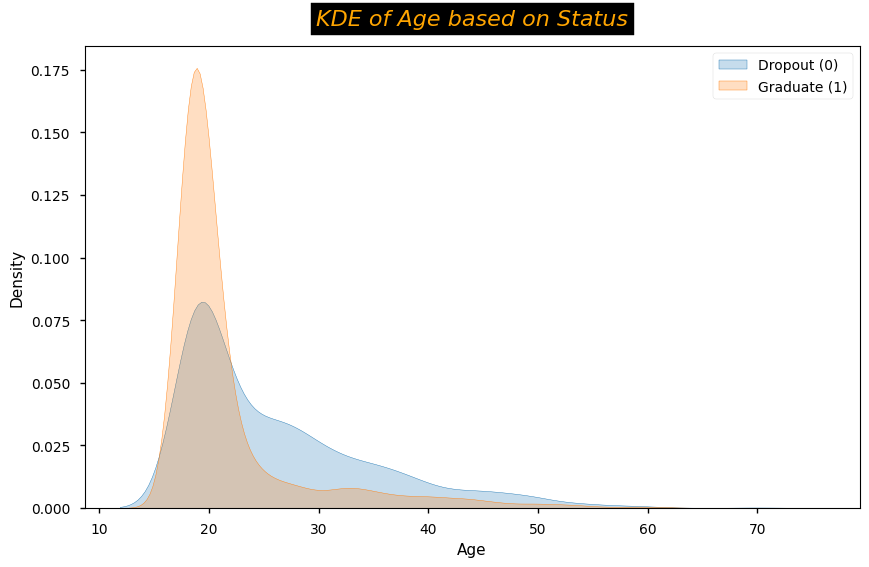

Train shape: (2904, 3), Test shape: (726, 3)


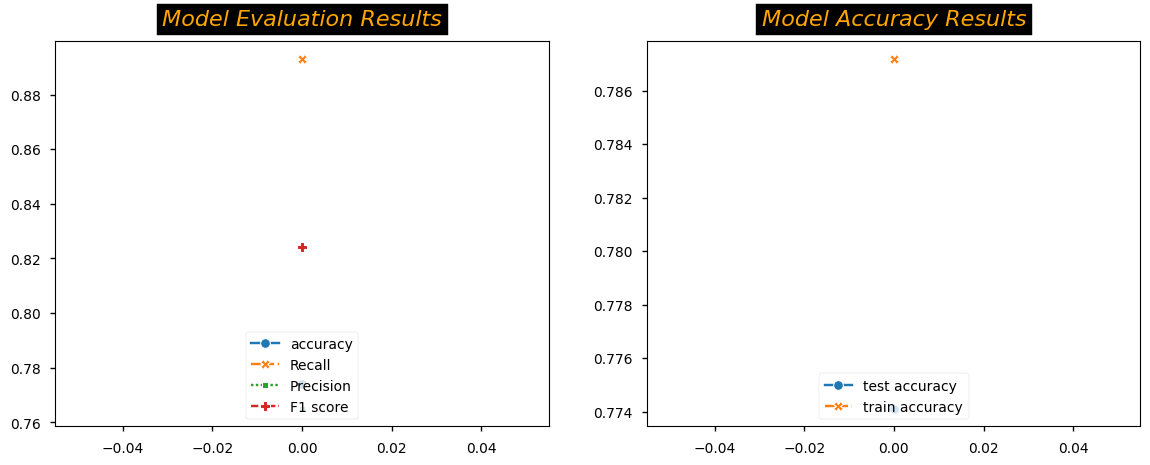

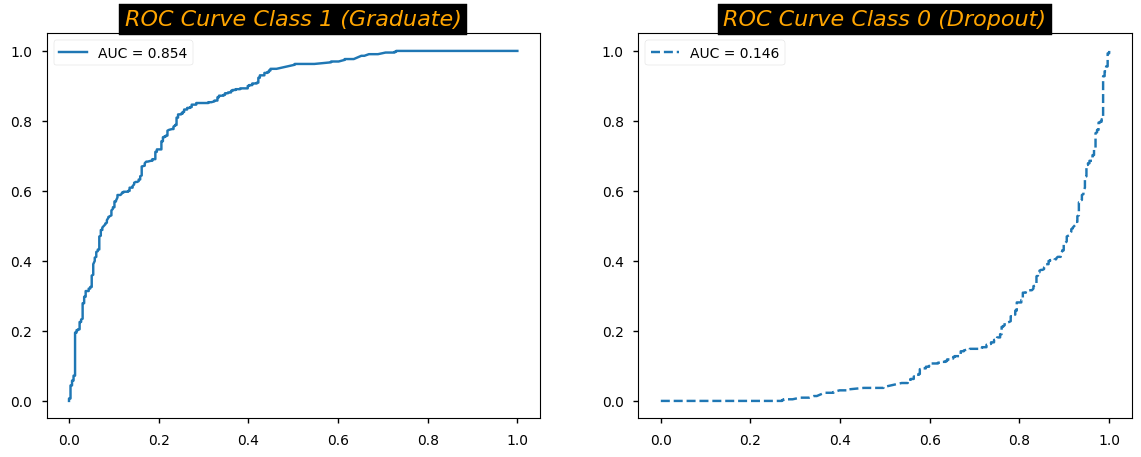

Confusion Matrix:
 [[178 118]
 [ 46 384]]


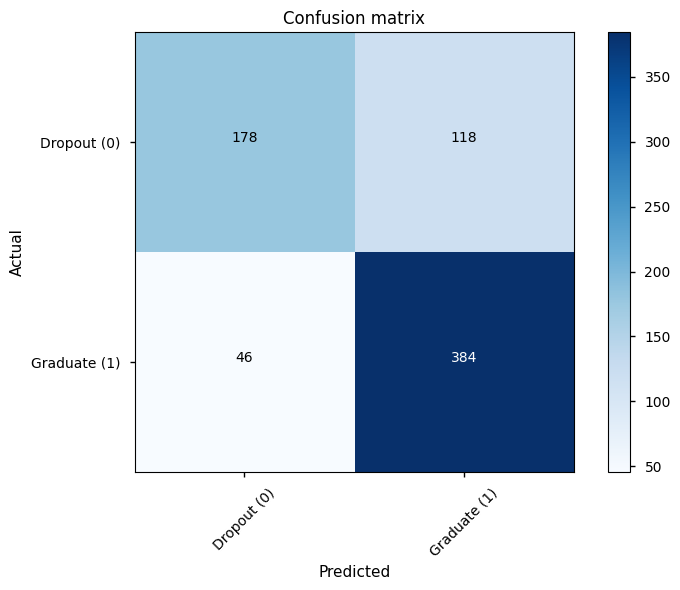

              precision    recall  f1-score   support

 Dropout (0)       0.79      0.60      0.68       296
Graduate (1)       0.76      0.89      0.82       430

    accuracy                           0.77       726
   macro avg       0.78      0.75      0.75       726
weighted avg       0.78      0.77      0.77       726

-------------------- CV for k=5, scoring=accuracy --------------------
CV mean: 0.7842975206611571
CV results: [0.77548209 0.80027548 0.79063361 0.78099174 0.77410468]



New Sample Data:
   Gender  Age  EstimatedSalary
0       1   20             14.5
Predicted Class: 1 (Graduate)


In [3]:
# import requirement libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import warnings

# Settings
warnings.filterwarnings('ignore')
# Handling plotly rendering (opsional jika di notebook lokal/colab)
try:
    from plotly.offline import init_notebook_mode
    init_notebook_mode(connected=True)
except:
    pass
plt.style.use('seaborn-v0_8-notebook') # Style yang aman

# --------------------------------------------------------------------------------------
# 1. IMPORT & PREPARE DATASET
# --------------------------------------------------------------------------------------
data = pd.read_csv('dataset (1).csv')

# Preprocessing Khusus Dataset Mahasiswa:
# 1. Pilih kolom yang relevan untuk menggantikan Age & Salary
#    - Age -> 'Age at enrollment'
#    - Salary -> 'Curricular units 2nd sem (grade)' (Kita pakai Nilai sebagai fitur kontinu)
#    - Purchased -> 'Target'
#    - Gender -> 'Gender'
df_selected = data[['Gender', 'Age at enrollment', 'Curricular units 2nd sem (grade)', 'Target']].copy()

# 2. Rename kolom agar sesuai dengan variabel di sisa kodingan
df_selected.columns = ['Gender', 'Age', 'EstimatedSalary', 'Purchased']

# 3. Filter Target: Hapus 'Enrolled' agar jadi Binary Classification (Dropout vs Graduate)
df = df_selected[df_selected['Purchased'] != 'Enrolled'].copy()

# 4. Encoding Target: Dropout=0, Graduate=1
df['Purchased'] = df['Purchased'].map({'Dropout': 0, 'Graduate': 1})

# Cek data
print(f"shape: {df.shape}")
print(df.head())
print(df.info())

# Check missing value
print(df.isnull().sum().to_frame('NaN value').T)

# --------------------------------------------------------------------------------------
# 2. EXPLORATORY DATA ANALYSIS (EDA)
# --------------------------------------------------------------------------------------

# check distribution of EstimatedSalary (Nilai Grade) based on Purchased (Kelulusan)
font = {'fontsize':16, 'fontstyle':'italic', 'backgroundcolor':'black', 'color':'orange'}

plt.figure(figsize=(10, 6))
sns.kdeplot(df.loc[df['Purchased'] == 0, 'EstimatedSalary'], label='Dropout (0)', shade=True)
sns.kdeplot(df.loc[df['Purchased'] == 1, 'EstimatedSalary'], label='Graduate (1)', shade=True)
plt.title('KDE of Grade (mapped as Salary) based on Status', fontdict=font, pad=15)
plt.legend()
plt.show()

# check distribution of Age based on Purchased
plt.figure(figsize=(10, 6))
sns.kdeplot(df.loc[df['Purchased'] == 0, 'Age'], label='Dropout (0)', shade=True)
sns.kdeplot(df.loc[df['Purchased'] == 1, 'Age'], label='Graduate (1)', shade=True)
plt.title('KDE of Age based on Status', fontdict=font, pad=15)
plt.legend()
plt.show()

# --------------------------------------------------------------------------------------
# 3. FEATURE SCALING & MODELING PREPARATION
# --------------------------------------------------------------------------------------
df2 = df.copy()

# standardize 'EstimatedSalary' (Grade) with MinMaxScaler
# Note: MultinomialNB requires positive features.
scaler = MinMaxScaler(feature_range=(0, 20)).fit(df[['EstimatedSalary']])
df2['EstimatedSalary'] = scaler.transform(df2['EstimatedSalary'].values.reshape(-1,1))

# define x (features) and y (target)
x = np.asanyarray(df2.drop('Purchased', axis=1))
y = df2.Purchased.values.reshape(-1,1)

# Inisialisasi list penyimpanan metrik
FPR1, TPR1, FPR0, TPR0 = [], [], [], []
ACC_test, ACC_train = [], []
Recall, Precision, F1 = [], [], []

# --------------------------------------------------------------------------------------
# 4. HELPER FUNCTIONS (Plotting & Cross Val)
# --------------------------------------------------------------------------------------
def plot_confusion_matrix2(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt ='d'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

def Perform_cross_val(model, k, x, y, scoring):
    kf = KFold(n_splits=k)
    cv_results = cross_val_score(model, x, y, cv=kf, scoring=scoring)
    print('-'*20, f"CV for k={k}, scoring={scoring}", '-'*20)
    print(f"CV mean: {np.mean(cv_results)}")
    print(f"CV results: {cv_results}\n")

def plot_results(FPR0, TPR0, FPR1, TPR1, ACC_test, ACC_train, Recall, Precision, F1):
    fig, ax = plt.subplots(1,2,figsize=(14,5))
    
    # plot model evaluation
    ax[0].set_title('Model Evaluation Results', fontdict=font, y=1.02)
    sns.lineplot(data=pd.DataFrame({
        'accuracy': ACC_test, 'Recall': Recall,
        'Precision': Precision, 'F1 score': F1
    }), markers=True, ax=ax[0])
    ax[0].legend(loc='lower center')

    # plot model accuracy train vs test
    ax[1].set_title('Model Accuracy Results', fontdict=font, y=1.02)
    sns.lineplot(data=pd.DataFrame({
        'test accuracy': ACC_test, 'train accuracy': ACC_train
    }), markers=True, ax=ax[1])
    ax[1].legend(loc='lower center')
    plt.show()

    # Plot ROC
    fig, ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].set_title('ROC Curve Class 1 (Graduate)', fontdict=font)
    for fpr, tpr in zip(FPR1, TPR1):
        ax[0].plot(fpr, tpr, label=f"AUC = {round(metrics.auc(fpr, tpr),3)}")
    ax[0].legend()
    
    ax[1].set_title('ROC Curve Class 0 (Dropout)', fontdict=font)
    for fpr, tpr in zip(FPR0, TPR0):
        ax[1].plot(fpr, tpr, '--', label=f"AUC = {round(metrics.auc(fpr, tpr),3)}")
    ax[1].legend()
    plt.show()

def modeling(x, y, test_size, classes, is_add=1):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=0)
    print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")

    clf = MultinomialNB()
    clf.fit(x_train, y_train.ravel())

    y_pred_test = clf.predict(x_test)
    y_proba_test = clf.predict_proba(x_test)
    y_pred_train = clf.predict(x_train)

    cm = metrics.confusion_matrix(y_test, y_pred_test)
    
    # Metrics
    if is_add == 1:
        fpr1, tpr1, _ = metrics.roc_curve(y_test, y_proba_test[:,1])
        fpr0, tpr0, _ = metrics.roc_curve(y_test, y_proba_test[:,0])
        FPR1.append(fpr1); TPR1.append(tpr1)
        FPR0.append(fpr0); TPR0.append(tpr0)
        ACC_test.append(metrics.accuracy_score(y_test, y_pred_test))
        ACC_train.append(metrics.accuracy_score(y_train, y_pred_train))
        Recall.append(metrics.recall_score(y_test, y_pred_test))
        Precision.append(metrics.precision_score(y_test, y_pred_test))
        F1.append(metrics.f1_score(y_test, y_pred_test))
        
        plot_results(FPR0, TPR0, FPR1, TPR1, ACC_test, ACC_train, Recall, Precision, F1)

    print('Confusion Matrix:\n', cm)
    plot_confusion_matrix2(cm, classes)
    print(metrics.classification_report(y_test, y_pred_test, target_names=classes))
    
    return clf, metrics.accuracy_score(y_test, y_pred_test), metrics.accuracy_score(y_train, y_pred_train)

# --------------------------------------------------------------------------------------
# 5. EXECUTION
# --------------------------------------------------------------------------------------

# Model 1
clf1, acc_test1, acc_train1 = modeling(x, y, 0.2, ['Dropout (0)', 'Graduate (1)'])
Perform_cross_val(clf1, 5, x, y, scoring='accuracy')

# NOTE: Bagian penghapusan baris (df3) saya skip karena indeks-nya spesifik dataset lama.
# Kita langsung lanjut ke visualisasi 3D menggunakan Data Test.

# 3D Visualization
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# Reconstruct dataframe for visualization
x_test_viz = pd.DataFrame(x_test, columns=['Gender', 'Age', 'EstimatedSalary']) # Salary is actually Grade
x_test_viz['Purchased'] = y_test

# Plot
fig = px.scatter_3d(
    data_frame=x_test_viz,
    x='Age',
    y='EstimatedSalary', # Ini adalah Grade
    z='Purchased',
    color=clf1.predict(x_test).astype(str),
    color_discrete_map={'0':'red', '1':'green'},
    opacity=0.6,
    height=700,
    title='Visualization: Age vs Grade vs Status (Color=Prediction)'
)
fig.show()

# --------------------------------------------------------------------------------------
# 6. PREDICT NEW SAMPLE
# --------------------------------------------------------------------------------------
# Contoh Data Baru:
# Gender: 1 (Male), Age: 20 tahun, Grade: 14.5 (skala 0-20)
new_sample_raw = pd.DataFrame({'Gender': [1], 'Age': [20], 'EstimatedSalary': [14.5]})

print("New Sample Data:")
print(new_sample_raw)

# Scaling Grade sesuai scaler yang sudah dilatih
new_sample_scaled = new_sample_raw.copy()
new_sample_scaled['EstimatedSalary'] = scaler.transform(new_sample_raw[['EstimatedSalary']])

# Prediksi
result = clf1.predict(new_sample_scaled.values)
label = "Graduate" if result[0] == 1 else "Dropout"

print('='*38)
print(f"Predicted Class: {result[0]} ({label})")

GaussianNB

--- [1] Memuat Data ---
Data siap! Jumlah Sampel: 3630
   Gender  Age      Grade  Debtor  Tuition_Paid  Target
0       1   20   0.000000       0             1       0
1       1   19  13.666667       0             0       1
2       1   19   0.000000       0             0       0
3       0   20  12.400000       0             1       1
4       0   45  13.000000       0             1       1

--- [2] Melatih Model GaussianNB ---
✅ Akurasi Model: 82.37%

Classification Report:
              precision    recall  f1-score   support

     Dropout       0.83      0.68      0.75       277
    Graduate       0.82      0.92      0.87       449

    accuracy                           0.82       726
   macro avg       0.83      0.80      0.81       726
weighted avg       0.82      0.82      0.82       726


--- [3] Membuat Visualisasi ---


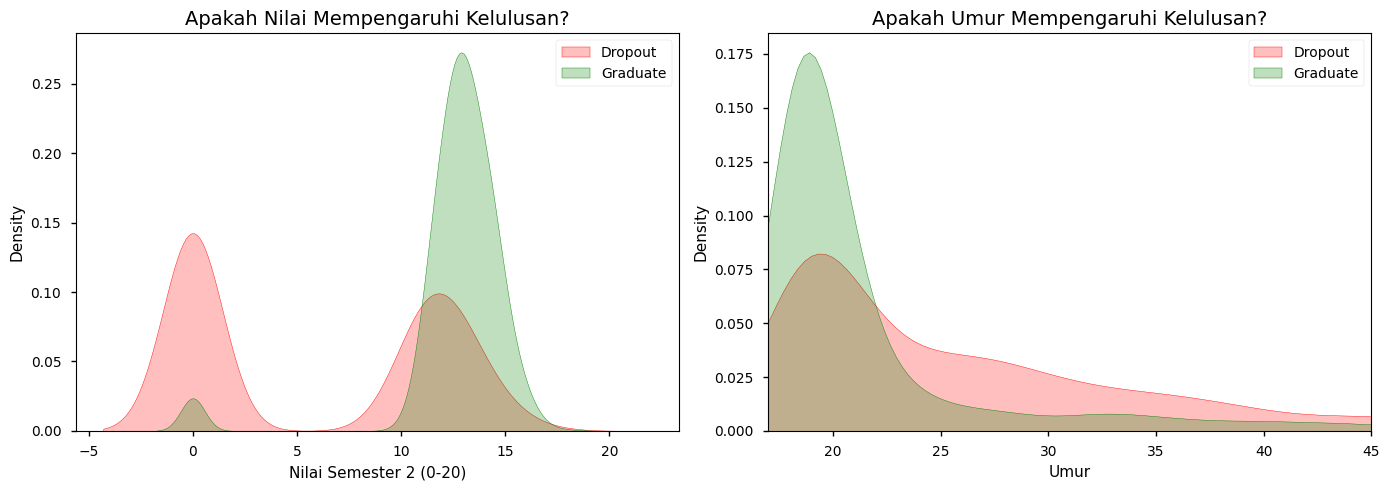

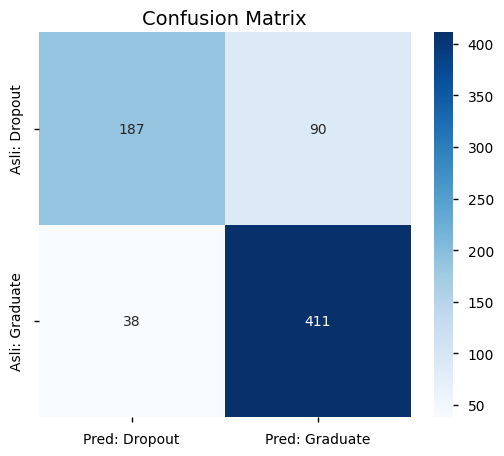


--- [4] Simulasi Prediksi Data Baru ---
1. Mahasiswa A (Nilai 15, Rajin Bayar) -> Diprediksi: Graduate (Yakin: 98.16%)
2. Mahasiswa B (Nilai 9, Nunggak)      -> Diprediksi: Dropout (Yakin: 100.00%)


In [4]:
# ==============================================================================
# TUGAS AKHIR 11: PREDIKSI KELULUSAN MAHASISWA (GAUSSIAN NAIVE BAYES)
# ==============================================================================

# 1. IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings

# Konfigurasi Tampilan
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-notebook')

# ------------------------------------------------------------------------------
# 2. LOAD & PREPARE DATA
# ------------------------------------------------------------------------------
print("--- [1] Memuat Data ---")
df = pd.read_csv('dataset (1).csv')

# Kita pilih 5 Fitur Utama yang paling mempengaruhi kelulusan:
# 1. Gender
# 2. Age at enrollment (Umur)
# 3. Curricular units 2nd sem (grade) (Nilai Semester 2)
# 4. Debtor (Punya Hutang?)
# 5. Tuition fees up to date (Bayar SPP Lancar?)
df_model = df[['Gender', 'Age at enrollment', 'Curricular units 2nd sem (grade)',
               'Debtor', 'Tuition fees up to date', 'Target']].copy()

# Rename kolom agar lebih mudah dipanggil
df_model.columns = ['Gender', 'Age', 'Grade', 'Debtor', 'Tuition_Paid', 'Target']

# Filter Target: Hapus status 'Enrolled', kita hanya ingin 'Dropout' vs 'Graduate'
df_model = df_model[df_model['Target'] != 'Enrolled'].copy()

# Encoding Target (Dropout=0, Graduate=1)
df_model['Target'] = df_model['Target'].map({'Dropout': 0, 'Graduate': 1})

print(f"Data siap! Jumlah Sampel: {df_model.shape[0]}")
print(df_model.head())

# ------------------------------------------------------------------------------
# 3. PREPROCESSING (SCALING & SPLITTING)
# ------------------------------------------------------------------------------
X = df_model.drop('Target', axis=1)
y = df_model['Target']

# Standard Scaling (WAJIB untuk Gaussian Naive Bayes)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ------------------------------------------------------------------------------
# 4. MODELING (GAUSSIAN NAIVE BAYES)
# ------------------------------------------------------------------------------
print("\n--- [2] Melatih Model GaussianNB ---")
model = GaussianNB()
model.fit(X_train, y_train)

# Prediksi Data Test
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"✅ Akurasi Model: {acc * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Dropout', 'Graduate']))

# ------------------------------------------------------------------------------
# 5. VISUALISASI (EDA & EVALUASI)
# ------------------------------------------------------------------------------
print("\n--- [3] Membuat Visualisasi ---")

# A. KDE Plot (Distribusi Nilai & Umur)
plt.figure(figsize=(14, 5))

# Plot Nilai (Grade)
plt.subplot(1, 2, 1)
sns.kdeplot(df_model.loc[df_model['Target'] == 0, 'Grade'], label='Dropout', fill=True, color='red')
sns.kdeplot(df_model.loc[df_model['Target'] == 1, 'Grade'], label='Graduate', fill=True, color='green')
plt.title('Apakah Nilai Mempengaruhi Kelulusan?', fontsize=14)
plt.xlabel('Nilai Semester 2 (0-20)')
plt.legend()

# Plot Umur (Age)
plt.subplot(1, 2, 2)
sns.kdeplot(df_model.loc[df_model['Target'] == 0, 'Age'], label='Dropout', fill=True, color='red')
sns.kdeplot(df_model.loc[df_model['Target'] == 1, 'Age'], label='Graduate', fill=True, color='green')
plt.title('Apakah Umur Mempengaruhi Kelulusan?', fontsize=14)
plt.xlabel('Umur')
plt.xlim(17, 45)
plt.legend()

plt.tight_layout()
plt.show()

# B. Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Dropout', 'Pred: Graduate'],
            yticklabels=['Asli: Dropout', 'Asli: Graduate'])
plt.title('Confusion Matrix', fontsize=14)
plt.show()

# C. 3D Scatter Plot (Interaktif)
# Kembalikan data X_test ke angka asli (Inverse Transform) agar grafik bisa dibaca
X_test_original = scaler.inverse_transform(X_test)
df_viz = pd.DataFrame(X_test_original, columns=['Gender', 'Age', 'Grade', 'Debtor', 'Tuition_Paid'])
df_viz['Status_Asli'] = y_test.values
df_viz['Prediksi'] = y_pred

# Mapping angka ke teks untuk label di grafik
df_viz['Status_Asli'] = df_viz['Status_Asli'].map({0: 'Dropout', 1: 'Graduate'})
df_viz['Prediksi'] = df_viz['Prediksi'].map({0: 'Dropout', 1: 'Graduate'})
df_viz['Punya_Hutang'] = df_viz['Debtor'].map({1: 'Ya', 0: 'Tidak'})

fig = px.scatter_3d(
    data_frame=df_viz,
    x='Age',
    y='Grade',
    z='Status_Asli',
    color='Prediksi',  # Warna titik berdasarkan Prediksi Model
    color_discrete_map={'Dropout': 'red', 'Graduate': 'green'},
    symbol='Punya_Hutang', # Bentuk titik beda jika punya hutang
    opacity=0.7,
    height=700,
    title='Visualisasi 3D: Umur vs Nilai vs Status (Warna=Prediksi, Bentuk=Hutang)'
)
fig.show()

# ------------------------------------------------------------------------------
# 6. SIMULASI PREDIKSI DATA BARU
# ------------------------------------------------------------------------------
print("\n--- [4] Simulasi Prediksi Data Baru ---")

# Buat 2 Data Dummy:
# Mhs A: Umur 20, Nilai 15 (Bagus), Tidak Hutang, SPP Lancar
# Mhs B: Umur 24, Nilai 9 (Jelek), Punya Hutang, SPP Nunggak
# Urutan: [Gender, Age, Grade, Debtor, Tuition_Paid]
data_baru = np.array([
    [1, 20, 15.0, 0, 1],
    [1, 24, 9.0,  1, 0]
])

# Scale data baru
data_baru_scaled = scaler.transform(data_baru)

# Prediksi
hasil = model.predict(data_baru_scaled)
prob = model.predict_proba(data_baru_scaled)

labels = {0: 'Dropout', 1: 'Graduate'}

print(f"1. Mahasiswa A (Nilai 15, Rajin Bayar) -> Diprediksi: {labels[hasil[0]]} (Yakin: {max(prob[0])*100:.2f}%)")
print(f"2. Mahasiswa B (Nilai 9, Nunggak)      -> Diprediksi: {labels[hasil[1]]} (Yakin: {max(prob[1])*100:.2f}%)")